# Section 5 : Multispectral Remote Sensing Data in Python
## Chapter 9 : Clouds, Shadows & Masks

[![Foo](https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder-one-line_0.png)](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/)

Les nuages sont un problème parmi d'autres dans le traitement de données géospatiales hyperspectrales comme ils empèchent d'avoir accès aux données au sol. Les nuages eux-mêmes occultent une partie de la vision au sol du fait de leur opacité mais leur ombre projetée peut également cacher des portions du sol pour des satellites géostationnaires ou encore des satellites aux orbites polaires avec une optique à faible contraste. Ainsi, si on réalise des analyses chiffrées sur les caractéristiques de la géographie, les valeurs moyennées peuvent contenir des erreurs dues à ces perturbations. Pour assurer une analyse pertinente des données géospatiales, il est nécessaire de prendre des contremesures pour pallier ces erreurs. Comme l'information est indisponible, il n'existe pas de solution parfaite mais on peut dans certains cas s'en affranchir comme pour des prises de vues périodiques où l'on peut remplacer la zone occultée par les valeurs similaires d'une image différée dans le temps. Pour le cas de cette étude, on se contente de masquer les pixels correspondant aux nuages et ombre portée. 

***
De la même façon que pour les autres notebooks, on commence par importer les packages Python nécessaires. Seaborn est un package de visulation de données statistiques. Il est basé sur la bibliothèque matplotlib et  permet de générer des graphiques intéressants et avec une mise en forme attrayante. 

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import seaborn as sns 
import numpy as np
from numpy import ma
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))


***
On importe également un cliché du sol avec les mêmes techniques que précédemment. A noter que pour la recherche `os.path.join` on importe seulement les bandes 2 à 5 pour RGB et NIR qui seront utilisées par la suite. Cette adaptation permet de générer un tableau multidimensionnel plus petit et donc de gagner du temps. 

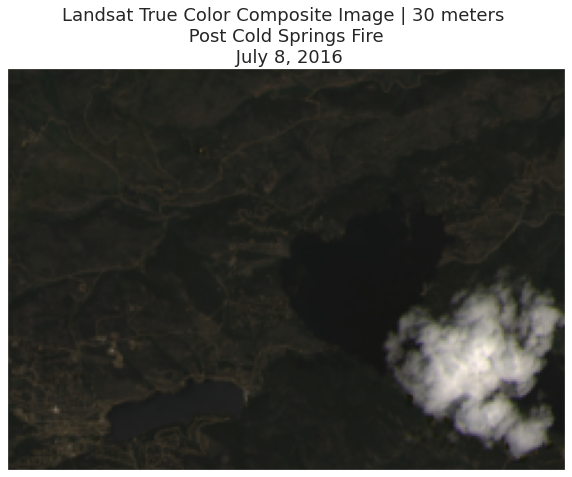

In [2]:
# Custom function to read in list of tifs into an xarray object
def combine_tifs(tif_list):
    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

landsat_paths_pre_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604",
                                      "crop",
                                      "*band[2-5]*.tif") 

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre = combine_tifs(landsat_paths_pre)

ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0],
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")

plt.show()


Comme noté dans l'introduction, la présence de ce nuage est un frein à une analyse quantitative des propriétés de l'image. Des techniques sont cependant disponibles pour s'affranchir de l'impact de sa présence sur l'analyse de l'image. Des masques peuvent être utilisés pour éviter de considérer cette zone dans des analyses quantitatives. On peut également remplacer les pixels inutilisables par ceux provenant d'une autre image pour le cas d'une série temporelle. 

De la même manière que dans le notebook précédent, on utilisera des masques pour faire disparaître les pixels inutilisables. Les pixels invalides et masqués seront tout simplement ignorés dans les prochaines transformations et fonctions. En pratique, les pixels masqués se voient attribués la valeur NaN pour signifier qu'ils sont invalides. Les prochaines lignes de code procèdent au masquage d'une image. 

***
Les images hyperspectrales sont souvent accompagnées de carte de masque pour identifier les endroits peu intéressants. Au moment de compiler les données hyperspectrales, le producteur peut faire un travail de prétraitement où il essaie de localiser les perturbations pour inclure ces informations essentielles dans son package. Dans le cas de données Landsat, en plus des images spectrales `*band*.tif`, on peut en trouver qui localisent des nuages, des ombres ou encore de l'eau avec des images au format `landsat_file_name_pixel_qa.tif`. Ce fichier est un tableau bidimensionnel où la valeur de chaque pixel indique si ce pixel est clairement visible ou occulté. La valeur du pixel correspond donc à la nature de l'occultation du pixel correspondant du tableau multidimensionnel `landsat_pre`. Vous pouvez retrouver la signification de chaque valeur dans le tableau de l'USGS reporté sur la [page](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/remove-clouds-from-landsat-data/) de l'Earth Lab.  

Par rapport à la latitude, la longitude, la saison et le degré de certitude a priori, on peut choisir les caractéristiques occultantes les plus probables dans cette image. Elles sont donc rassemblées dans la variable `all_masked_values`. Enfin, on impose le masque sur `landsat_pre` qui devient `landsat_pre_cl_free`. L'opération de masquage supprime tous les pixels de `landsat_pre` dont le pixel correspondant de la carte de perturbation `landsat_qa` fait référence à une valeur listée dans `all_masked_values`. `landsat_pre_cl_free` garde les mêmes dimensions que `landsat_pre` avec 4 images de taille 177x246 mais certains de ses pixels ont été rendus invalides par l'opération de masquage. Attention à ne pas oublier le ~ dans la fonction `rioxarray.where` ce qui inverserait l'effet et supprimerait tous les pixels qui sont annotés False dans le masque. 

In [3]:
# Open the landsat qa layer
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
print(all_masked_values)
# Call the earthpy mask function using pixel QA layer
landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))


[328, 392, 840, 904, 1350, 352, 368, 416, 432, 480, 864, 880, 928, 944, 992, 480, 992]


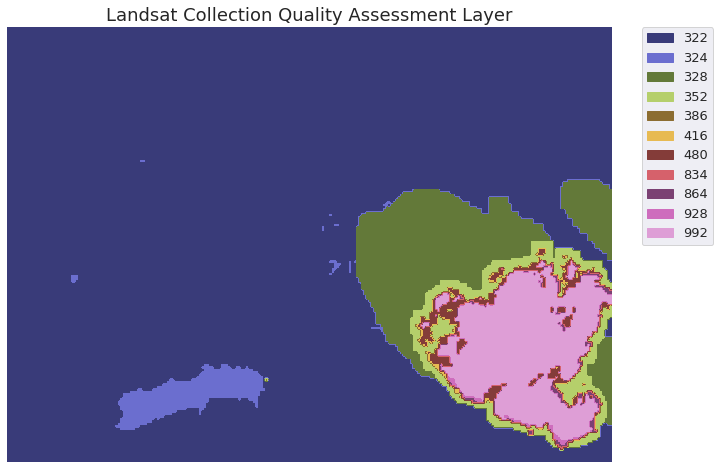

In [4]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 11 colors
cmap = plt.cm.get_cmap('tab20b', 11)
# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals
# Normalize the colormap
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()


***
On peut tracer maintenant la cartographie en proche infrarouge (NIR) de Cold Springs ou bien encore la cartographie visuel plus infrarouge (CIR) dans la cellule suivante. On s'aperçoit que la zone correspondant au nuage à bien été supprimée dans les deux images. Cependant, la zone de l'ombre projetée n'a pas correctement été supprimée dans les deux images. En effet, on voit dans l'image couleur de `landsat_qa` que le dessin de la zone du nuage en rose (code 928-992) correspond bien à ce que l'on peut voir sur l'image en vraies couleurs. Or, la zone de l'ombre du nuage en vert (code 328-352) est grossière et ne correspond pas à la forme projetée du nuage telle que l'on peut la voir sur l'image en vraies couleurs. Cette imprécision ne provient donc pas de la transformation informatique mais bien du "Quality Assessment Layer" qui a mal été réalisé. A noter que pour afficher la cartographie sur une seule bande spectrale, on utilise la fonction `ep.plot_bands()` plutôt que `ep.plot_rgb()`.

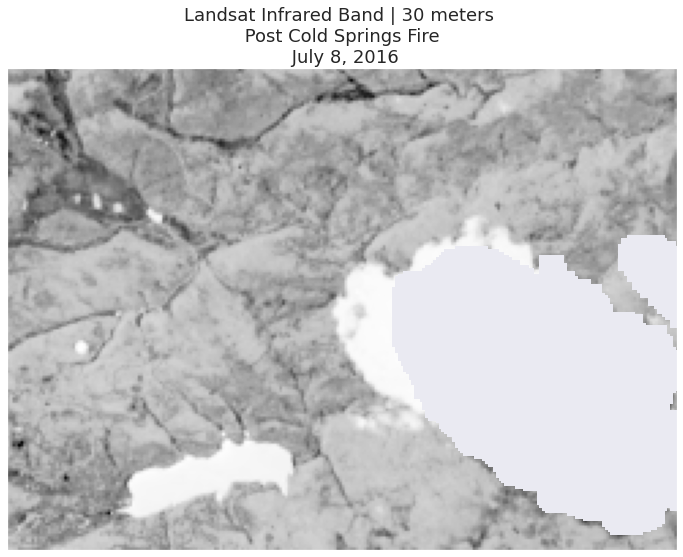

In [5]:
# Plot the data
ep.plot_bands(landsat_pre_cl_free[3],
              cmap="Greys",
              title="Landsat Infrared Band | 30 meters \n Post Cold Springs Fire \n July 8, 2016",
              cbar=False)
plt.show()


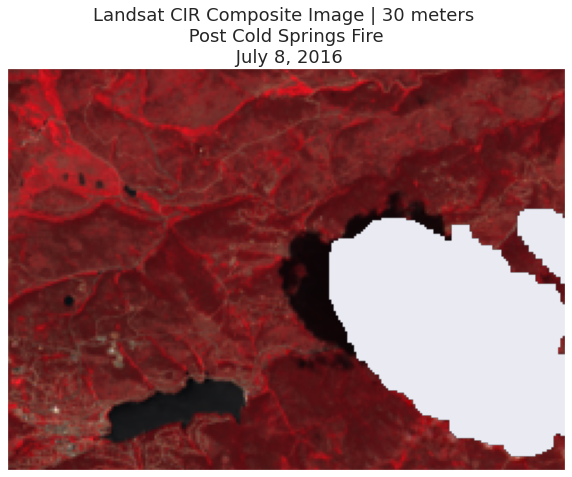

In [6]:
# Plot data
# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cl_free_plot = ma.masked_array(landsat_pre_cl_free.values, landsat_pre_cl_free.isnull())

# Plot
ep.plot_rgb(landsat_pre_cl_free_plot,
            rgb=[3, 2, 1],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()
